In [1]:
import CSV
import TypedTables: Table, columnnames
using Revise # Allow code updating

Load the isochrone table using `CSV.read` into a `TypedTables.Table` structure. This contains an isochrone table from PARSEC that has 26 steps in [M/H] and 71 steps in `logAge=log10(age [yr])` for a total of 1846 unique isochrones.

In [2]:
table = CSV.read("../../../../Work/Resources/isochrones/parsec/jwst/nircam_nov22/table.dat", Table; comment="#", delim=' ', ignorerepeated=true, 
    header=["Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label", "McoreTP", "C_O", "period0", "period1", "period2", 
        "period3", "period4", "pmode", "Mloss", "tau1m", "X",  "Y", "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", "mbolmag",  "F070W",  "F090W",  "F115W",  
        "F150W",  "F200W",  "F277W",  "F356W",  "F444W",  "F150W2",  "F322W2",  "F140M",  "F162M",  "F182M",  "F210M",  "F250M",  "F300M",  "F335M",  
        "F360M",  "F410M",  "F430M",  "F460M",  "F480M"])

Table with 50 columns and 709192 rows:
      Zini       MH        logAge  Mini      int_IMF  Mass   logL    logTe   ⋯
    ┌─────────────────────────────────────────────────────────────────────────
 1  │ 2.4652e-5  -2.19174  6.6     0.1       1.17111  0.1    -1.436  3.5769  ⋯
 2  │ 2.4652e-5  -2.19174  6.6     0.105145  1.2127   0.105  -1.411  3.5791  ⋯
 3  │ 2.4652e-5  -2.19174  6.6     0.109821  1.24828  0.109  -1.387  3.5809  ⋯
 4  │ 2.4652e-5  -2.19174  6.6     0.124     1.34512  0.124  -1.321  3.5865  ⋯
 5  │ 2.4652e-5  -2.19174  6.6     0.129464  1.37867  0.129  -1.298  3.5885  ⋯
 6  │ 2.4652e-5  -2.19174  6.6     0.140418  1.4407   0.14   -1.252  3.5923  ⋯
 7  │ 2.4652e-5  -2.19174  6.6     0.149107  1.4856   0.149  -1.219  3.595   ⋯
 8  │ 2.4652e-5  -2.19174  6.6     0.183261  1.63379  0.182  -1.1    3.6048  ⋯
 9  │ 2.4652e-5  -2.19174  6.6     0.197245  1.68445  0.196  -1.057  3.6085  ⋯
 10 │ 2.4652e-5  -2.19174  6.6     0.207292  1.71805  0.206  -1.029  3.6111  ⋯
 11 │ 2.4652e

Check the available columns in the table

In [3]:
columnnames(table)

(:Zini, :MH, :logAge, :Mini, :int_IMF, :Mass, :logL, :logTe, :logg, :label, :McoreTP, :C_O, :period0, :period1, :period2, :period3, :period4, :pmode, :Mloss, :tau1m, :X, :Y, :Xc, :Xn, :Xo, :Cexcess, :Z, :mbolmag, :F070W, :F090W, :F115W, :F150W, :F200W, :F277W, :F356W, :F444W, :F150W2, :F322W2, :F140M, :F162M, :F182M, :F210M, :F250M, :F300M, :F335M, :F360M, :F410M, :F430M, :F460M, :F480M)

In [4]:
unique(table.MH) # These are metallicities, [M/H]

26-element Vector{Float64}:
 -2.19174
 -2.1
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
 -0.7
 -0.6
 -0.5
 -0.4
 -0.3
 -0.2
 -0.1
  0.0
  0.1
  0.2
  0.3

In [5]:
unique(table.logAge) # These are `log10(age)`, where the age is in years.

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001

## Observational Model 

We'll construct a model Hess diagram from the populations in this isochrone table. First we need to set up our observational models for photometric error and incompleteness. You would typically measure these from artificial star tests but we'll make up some models here using functions built into StarFormationHistories.jl.

In [6]:
import StarFormationHistories: Martin2016_complete, exp_photerr

[ Info: Precompiling StarFormationHistories [774d3ad4-2d55-48fa-ab42-467705ebff24]


In [7]:
distmod = 25.0 # Distance modulus 
F090W_complete(m) = Martin2016_complete(m,1.0,28.5,0.7)
F150W_complete(m) = Martin2016_complete(m,1.0,27.5,0.7)
F090W_error(m) = min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 )
F150W_error(m) = min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 )

F150W_error (generic function with 1 method)

We'll make a few plots showing the adopted models. Below we set up PyPlot.jl (a wrapper for Python's matplotlib package).

In [8]:
import PyPlot as plt
import PyPlot: @L_str # For LatexStrings
import PyCall: @pyimport
plt.rc("text", usetex=true)
plt.rc("font", family="serif", serif=["Computer Modern"], size=14)
plt.rc("figure", figsize=(5,5))
plt.rc("patch", linewidth=1, edgecolor="k", force_edgecolor=true) 

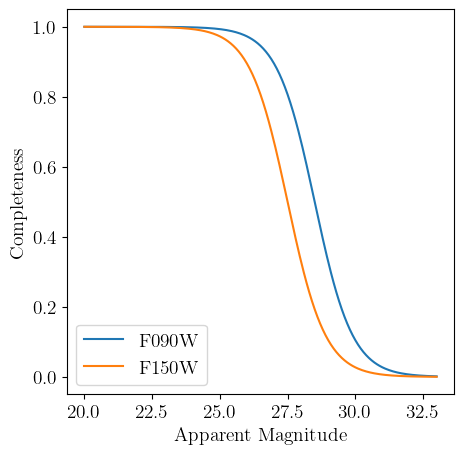

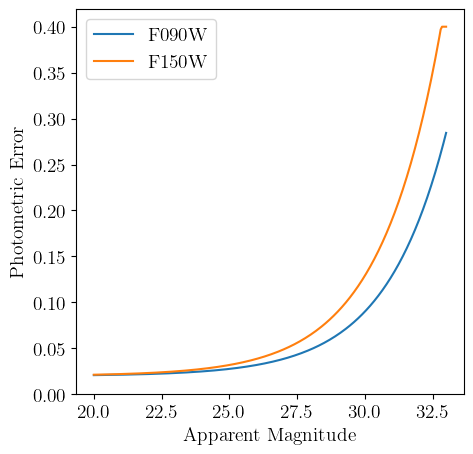

(0.0, 0.41895850114873723)

In [9]:
plotmags=20.0:0.05:33.0

fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_complete.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_complete.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Completeness")
ax1.legend(loc="lower left")

plotmags=20.0:0.05:33.0
fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_error.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_error.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Photometric Error")
ax1.legend(loc="upper left")
ax1.set_ylim([0.0,ax1.get_ylim()[2]])

We put a maximum on the magnitude error in the model because most of the time one would place a cut on the photometric catalog in either signal to noise (e.g., SNR>5) or magnitude error (e.g., error < 0.4). From a practical perspective, if we allow the photometric error model to grow too large, it will hurt the efficiency of `partial_cmd_smooth` for template creation later.

## Template Construction

We may now define our mock star formation history. We will use `partial_cmd_smooth` to construct the templates for a Hess diagram model with F150W on the y-axis and F090W-F150W on the x-axis, with an initial mass function model from InitialMassFunctions.jl. We'll construct all 1846 templates, one for every isochrone in our table, but this may not always be necessary.

In [10]:
import StarFormationHistories: partial_cmd_smooth
import InitialMassFunctions: Kroupa2001

In [11]:
# Some additional setup
imf = Kroupa2001(0.08, 100.0) # Initial mass function model
unique_logAge = unique(table.logAge)
# Think there might be an issue with the youngest isochrones
# unique_logAge = unique_logAge[unique_logAge .>= 7]
unique_MH = unique(table.MH)
template_norm = 1e3 # The stellar mass of the populations in each template
edges = (range(-0.5, 1.6, length=100), range(distmod-8.0, distmod+3.0, length=100)) # The bin edges for the Hess diagrams (17,28)

(-0.5:0.021212121212121213:1.6, 17.0:0.1111111111111111:28.0)

In [12]:
# Constructing the templates
templates = Vector{Matrix{Float64}}(undef,0)
template_logAge = Vector{Float64}(undef,0)
template_MH = Vector{Float64}(undef,0)
# We don't strictly need to save the initial masses (m_ini) or the isochrone magnitudes (iso_mags), 
# but we'll use them later in this example so we'll save them now. 
template_mini = Vector{Vector{Float64}}(undef,0)
template_isomags = Vector{Vector{Vector{Float64}}}(undef,0)
for logage in unique_logAge 
    for mh in unique_MH
        # Combination of a logage and an MH defines a unique isochrone.
        # Pick out all entries in `table` that match this combination; these will be row indices
        # into the table of the stars in this specific isochrone.
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last entry in the isochrone because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
        push!(template_mini, m_ini)
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
        push!(template_isomags, iso_mags)
        # Create template and push
        push!(templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(template_logAge, logage)
        push!(template_MH, mh)
    end
end

In [13]:
# Sort the template_logAge and template_MH so we have a guarantee for later
permidx = sortperm(template_logAge)
template_logAge = template_logAge[permidx]
template_MH = template_MH[permidx]
templates = templates[permidx]

1846-element Vector{Matrix{Float64}}:
 [0.0 5.308707755624576e-10 … 0.0 0.0; 6.906811253133398e-14 1.5108610725823887e-8 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 

We'll plot a few templates for reference.

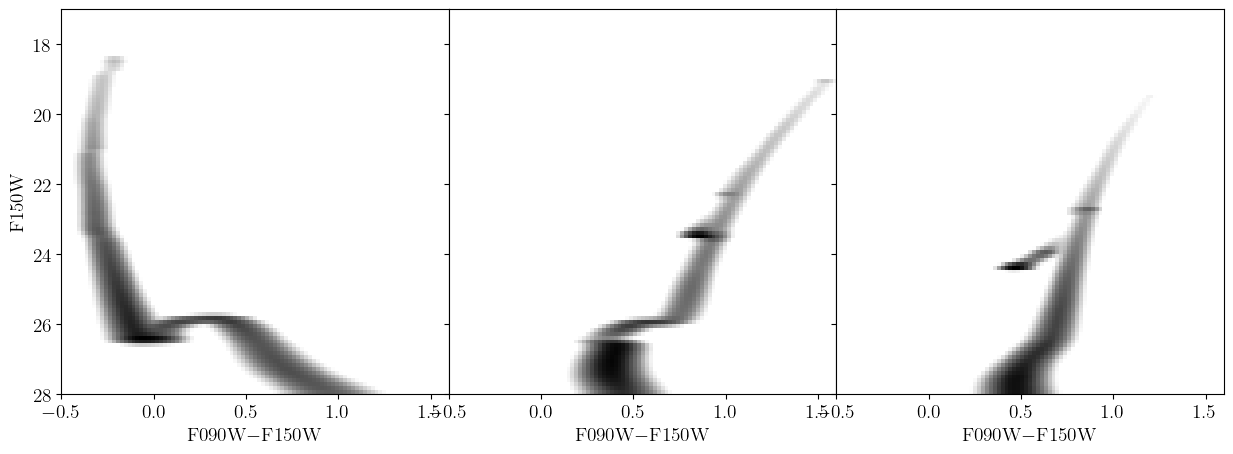

(-0.5, 1.6)

In [14]:
fig,axs=plt.subplots(1,3,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

axs[1].imshow(permutedims(templates[100]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[2].imshow(permutedims(templates[1500]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[3].imshow(permutedims(templates[1800]), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
# im1.set_clim( [0.5, im1.get_clim()[2]] )
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))

## Building a Model Hess Diagram

We may now use `construct_x0_mdf` and `calculate_coeffs_mdf` to create a mock star formation history with constant star formation rate and a reasonable metallicity evolution for a dwarf galaxy. 

In [15]:
import StarFormationHistories: construct_x0_mdf, calculate_coeffs_mdf

In [16]:
# Set overall stellar mass of complex population and metallicity evolution variables
stellar_mass = 1e7
α, β, σ = -0.1, -0.5, 0.3
# max_logage sets the highest bin edge for the template_logAge
# if template_logage was [6.6,6.7,6.8], I would set max_logAge=6.9, 
# representing the rightmost bin edge. In our case, our oldest template
# is quite old, so we'll make it either the Hubble time or the maximum of 
# template_logAge plus the isochrone logage grid spacing, which is 0.05.
max_logAge = min(log10(13.7e9), maximum(template_logAge) + 0.05)
# We have to divide `stellar_mass` by `template_norm` here because `template_norm` is the total amount of stellar mass in each template, since we passed `normalize_value=template_norm` 
# when constructing the templates with `partial_cmd_smooth`. As such, when computing coefficients, we need to normalize out the adopted `normalize_value` for the templates.
x0_mdf = construct_x0_mdf(template_logAge, max_logAge; normalize_value=stellar_mass / template_norm)

71-element Vector{Float64}:
   0.35467548527633025
   0.39795243976854044
   0.44650998135479286
   0.5009924391101028
   0.5621227621472873
   0.6307121127124622
   0.707670629815149
   0.7940195062200915
   0.8909045390546746
   0.9996113338407291
   1.121582363698718
   1.2584361100895582
   1.4119885390804594
   ⋮
 316.1121376527193
 354.6836520752058
 397.96160306759907
 446.5202627454224
 501.0039750201435
 562.1357056512201
 630.7266355627485
 707.686924721193
 794.0377894053546
 890.9250531259761
 999.6343510072664
 810.787431184313

The above coefficients are the amount of stellar mass formed in each age bin of `unique(template_logAge)`. To construct the complex Hess diagram, we need individual per-template weights, which we can get with `calculate_coeffs_mdf`.

In [17]:
x0 = calculate_coeffs_mdf(x0_mdf, template_logAge, template_MH, α, β, σ)

1846-element Vector{Float64}:
 5.9235531404504195e-9
 3.169696106784342e-8
 1.773279231830264e-7
 8.87731614736121e-7
 3.976777593066563e-6
 1.5941382306528427e-5
 5.718283840220748e-5
 0.0001835483555568784
 0.000527206000554763
 0.0013550497766847323
 0.003116557979854118
 0.006414166515380322
 0.01181273080861286
 ⋮
 0.6845437240264519
 0.22311605801628812
 0.0650737030177555
 0.016983424746143255
 0.003966341271769308
 0.0008288958101708169
 0.00015500826931984764
 2.5939096681050027e-5
 3.884184813974202e-6
 5.204631448827413e-7
 6.240582585074057e-8
 6.695844288441627e-9

Let's plot the cumulative SFH and mean [M/H] of our model population.

In [18]:
import StarFormationHistories: calculate_cum_sfr
unique_template_logAge, cum_sfr_arr, sfr_arr, mean_mh_arr = calculate_cum_sfr(x0, template_logAge, max_logAge, template_MH; normalize_value=template_norm)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999991, 0.9999645324514715, 0.9999247372074946, 0.9998800862093592, 0.9998299869654482, 0.9997737746892335, 0.9997107034779623, 0.9996399364149808, 0.9995605344643589, 0.9994714440104535  …  0.6741419731491235, 0.6343458128423636, 0.5896937865678213, 0.539593389065807, 0.48337981850068507, 0.4203071549444102, 0.34953846247229087, 0.27013468353175546, 0.1810421782191579, 0.08107874311843127], [0.0007301391778410212, 0.0007301391778410211, 0.0007301391778410212, 0.0007301391778410212, 0.0007301391778410211, 0.0007301391778410211, 0.0007301391778410209, 0.000730139177841021, 0.0007301391778410211, 0.0007301391778410212  …  0.0007301391778410212, 0.0007301391778410213, 0.0007301391778410212, 0.0007301391778410206, 0.0007301391778410213, 0.0007301391778410213, 0.0007301391778410213, 0.0007301391778410211, 0.0007301391778410211

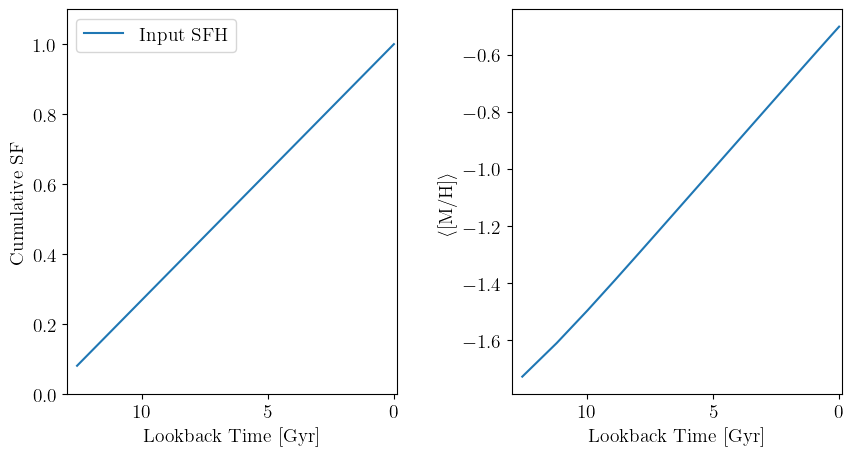

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [19]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

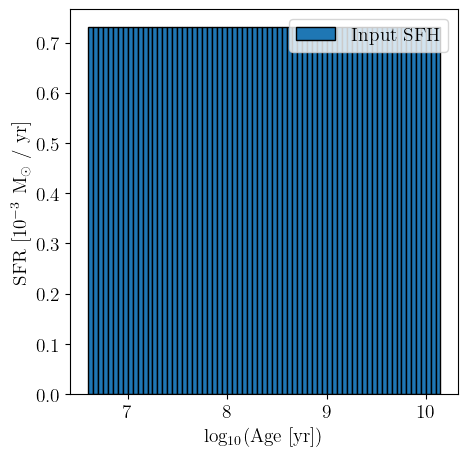

PyObject <matplotlib.legend.Legend object at 0x7fd5e469d5d0>

In [20]:
fig,ax1 = plt.subplots()
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.set_xlabel(L"log$_{10}$(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Now let's make a model Hess diagram with this SFH. We can simply write `composite = sum( coeffs .* models)` if we want, but we also provide the `composite!` function that is more efficient.

In [21]:
model1 = sum( x0 .* templates)

99×99 Matrix{Float64}:
 0.0          3.14464e-18  7.65064e-17  …  0.0          0.0
 4.09129e-22  8.94967e-17  1.88074e-15     0.0          0.0
 9.68593e-20  1.54626e-15  2.73033e-14     1.59987e-20  0.0
 4.53728e-18  1.67253e-14  2.34952e-13     1.17264e-14  2.65129e-17
 1.61504e-16  1.21029e-13  1.2051e-12      6.3312e-11   6.01633e-13
 1.0688e-12   5.46724e-12  6.54459e-12  …  5.71462e-9   8.00722e-11
 1.65114e-10  8.74801e-10  3.00147e-9      1.00817e-7   2.47468e-9
 6.76813e-9   2.65496e-8   8.30648e-8      8.22682e-7   3.31363e-8
 1.43759e-7   4.83839e-7   1.3659e-6       4.49405e-6   2.5292e-7
 1.89638e-6   5.46908e-6   1.36346e-5      1.94835e-5   1.33234e-6
 1.56865e-5   3.8468e-5    8.38721e-5   …  7.32318e-5   5.64157e-6
 8.24994e-5   0.000170622  0.000325484     0.000247205  2.05662e-5
 0.000283815  0.000491119  0.000827194     0.000768615  6.79475e-5
 ⋮                                      ⋱               
 0.0353949    0.0408926    0.0407868       0.000541231  0.000528845


In [22]:
model2 = similar(model1)
import StarFormationHistories: composite!
composite!(model2, x0, templates)
model2

99×99 Matrix{Float64}:
 0.0          3.14464e-18  7.65064e-17  …  0.0          0.0
 4.09129e-22  8.94967e-17  1.88074e-15     0.0          0.0
 9.68593e-20  1.54626e-15  2.73033e-14     1.59987e-20  0.0
 4.53728e-18  1.67253e-14  2.34952e-13     1.17264e-14  2.65129e-17
 1.61504e-16  1.21029e-13  1.2051e-12      6.3312e-11   6.01633e-13
 1.0688e-12   5.46724e-12  6.54459e-12  …  5.71462e-9   8.00722e-11
 1.65114e-10  8.74801e-10  3.00147e-9      1.00817e-7   2.47468e-9
 6.76813e-9   2.65496e-8   8.30648e-8      8.22682e-7   3.31363e-8
 1.43759e-7   4.83839e-7   1.3659e-6       4.49405e-6   2.5292e-7
 1.89638e-6   5.46908e-6   1.36346e-5      1.94835e-5   1.33234e-6
 1.56865e-5   3.8468e-5    8.38721e-5   …  7.32318e-5   5.64157e-6
 8.24994e-5   0.000170622  0.000325484     0.000247205  2.05662e-5
 0.000283815  0.000491119  0.000827194     0.000768615  6.79475e-5
 ⋮                                      ⋱               
 0.0353949    0.0408926    0.0407868       0.000541231  0.000528845


In [23]:
model1 ≈ model2

true

Let's plot the smooth model.

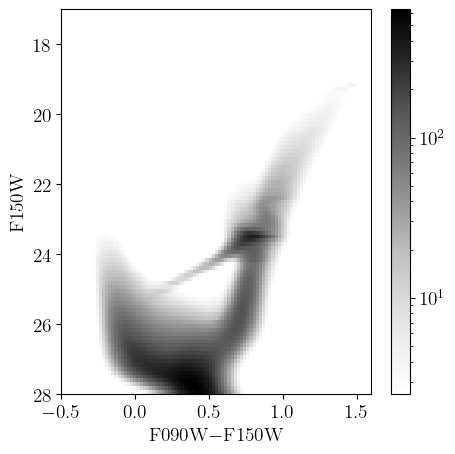

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5e45f6620>

In [24]:
fig,ax1=plt.subplots()

im1=ax1.imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
ax1.set_xlabel(L"F090W$-$F150W")
ax1.set_ylabel("F150W")
ax1.set_ylim(reverse(extrema(edges[2]))) 
ax1.set_xlim(extrema(edges[1]))
fig.colorbar(im1)

## Sampling Methods for CMDs and Hess Diagrams

The templates are constructed such that the 2D histogram pixel values give the expected number of stars in that bin for a population with total stellar mass `normalize_value` (in our case we defined the variable `template_norm=1e3` and used that as our `normalize_value` for the templates). As such the pixel values of this complex model also represent expected numbers of stars per bin for our defined SFH. We may, therefore, simply Poisson sample it to obtain a reasonable observational realization of the Hess diagram:

In [25]:
import Distributions: Poisson
import Random: AbstractRNG, default_rng
function poisson_sample!(sample::T, model::S, rng::AbstractRNG=default_rng()) where {T <: AbstractArray{<:Number}, S <: AbstractArray{<:Number}}
    @assert axes(sample) == axes(model)
    for i in eachindex(sample, model)
        sample[i] = rand(rng,Poisson(model[i]))
    end
end
poisson_sample(model::AbstractArray{<:Number}, rng::AbstractRNG=default_rng()) = (sample = similar(model); poisson_sample!(sample, model, rng); return sample)
model3 = poisson_sample(model2)

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

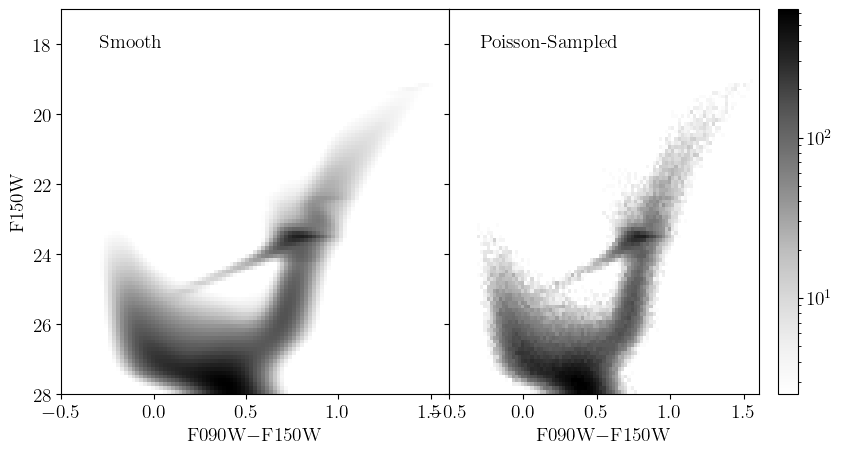

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5e41fc2e0>

In [26]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1, ax=axs[2])

To sample the color-magnitude diagram (CMD) directly we could use `generate_stars_mass_composite`,

In [27]:
import StarFormationHistories: generate_stars_mass_composite, NoBinaries
starcat = generate_stars_mass_composite(template_mini, template_isomags, ["F090W", "F150W"], stellar_mass, x0, imf; dist_mod=distmod, binary_model=NoBinaries())

([[0.10664769510076075], [0.44180878880309693], [0.24442199188352426], [2.2601735374054694], [0.13926531818464002], [0.3609707845652799], [0.2653184655700552], [0.19389256364286675], [0.4634230433191647, 0.3410328527950701], [0.1213372643945678, 0.28015898877986917, 0.390119846481783, 1.1719775687570084]  …  [0.16602449331956856, 0.17175008449958631, 0.164150057754812, 0.09914602774848086, 0.12990109925803867, 0.13265877989420893, 0.3042788955118698, 0.3227982723785708, 0.16434914144449364, 0.28413603686063327  …  0.10777678761629036, 0.15962445733006925, 0.09282831653521854, 0.16289069278567214, 0.1410655307989909, 0.11430458307674435, 0.2641436040506558, 0.4189986651059763, 0.1593946771925523, 0.47657691909151967], [0.3092484183261665, 0.10511715700148283, 0.3204387845156903, 0.16954438976712907, 0.21811265999020152, 0.3168759613965122, 0.4237630689467908, 0.4736002211386283, 0.18154399377103525, 0.31638213861641573  …  0.29283816834776216, 0.5871089909322496, 0.46498285832716285, 0.

We'll concatenate the per-population samples returned from `generate_stars_mass_composite` into a single `Vector{SVector}`. 

In [28]:
# starcat_mags = reduce(hcat,reduce(vcat,starcat[2])) # For 2D matrix
starcat_mags = reduce(vcat,starcat[2])

14746145-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [32.30082961309367, 31.20618367192794]
 [30.27443373276379, 29.364093785163043]
 [31.186746651214747, 30.12150719905604]
 [26.969268104195617, 27.10128545890672]
 [32.00653049351491, 30.855199886482545]
 [30.66190897898182, 29.593248705155023]
 [31.14339758662413, 30.016310237460125]
 [31.60615870506077, 30.441674957200735]
 [30.333597523195426, 29.239059379196014]
 [30.79055812306167, 29.656407645234513]
 [32.17426871532743, 30.971628973755045]
 [31.076686477047488, 29.916765288424642]
 [30.62355799370657, 29.48766658395156]
 ⋮
 [35.01686394061288, 33.722270394457034]
 [34.89490998312115, 33.61060698634073]
 [35.56870557572891, 34.21902480198927]
 [34.583328701635295, 33.32336641199019]
 [34.94516989204686, 33.65662593347199]
 [36.08106069928903, 34.66564916834685]
 [36.290877751491934, 34.842771960573884]
 [37.2014480242089, 35.6364480242089]
 [37.22249934680084, 35.45433795577383]
 [29.936121437642832, 29.12111894821108

Now we'll mock observe the "pure" catalog with the same observational models we used to construct the templates using `model_cmd`.

In [29]:
import StarFormationHistories: model_cmd
obs_mags = model_cmd( starcat_mags, [F090W_error, F150W_error], [F090W_complete, F150W_complete] )

212338-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [26.982816670852188, 27.04203514100967]
 [22.40758277144406, 22.793050391587848]
 [26.800513096066933, 26.42981822803915]
 [24.18567417861391, 24.46558997624771]
 [22.94010075552418, 23.291880368964375]
 [26.458291629136614, 26.39376322883498]
 [29.21619531685591, 28.437214118176854]
 [26.143837154054257, 26.303740046424547]
 [26.43241473650982, 26.430880081704487]
 [26.223122881882755, 26.164716223329055]
 [26.525422692650153, 26.7270777652983]
 [23.35603758899287, 23.667704823487504]
 [26.602298417853305, 26.13891743202661]
 ⋮
 [28.000606308365956, 27.47167865849779]
 [27.63527775193021, 26.977734529655677]
 [28.15877076610908, 27.689073511327116]
 [28.04278748833574, 27.426168802832986]
 [27.705682612712305, 27.024206404884577]
 [23.883551856640644, 22.99363619618971]
 [26.322423474893878, 25.56120291874722]
 [27.725911270930375, 27.096137645010497]
 [24.628634459197325, 23.88257864821885]
 [25.28075078793866, 24.34871409

Now we'll compute the Hess diagram with `bin_cmd` and compare with our smooth and Poisson-sampled versions. 

In [30]:
# Concatenate into 2D matrix
obs_mags = reduce(hcat,obs_mags)

2×212338 Matrix{Float64}:
 26.9828  22.4076  26.8005  24.1857  …  24.6286  25.2808  28.4415  29.2394
 27.042   22.7931  26.4298  24.4656     23.8826  24.3487  27.7409  28.5981

In [31]:
import StarFormationHistories: bin_cmd
model4 = bin_cmd(view(obs_mags,1,:) .- view(obs_mags,2,:), view(obs_mags,2,:), edges=edges).weights

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

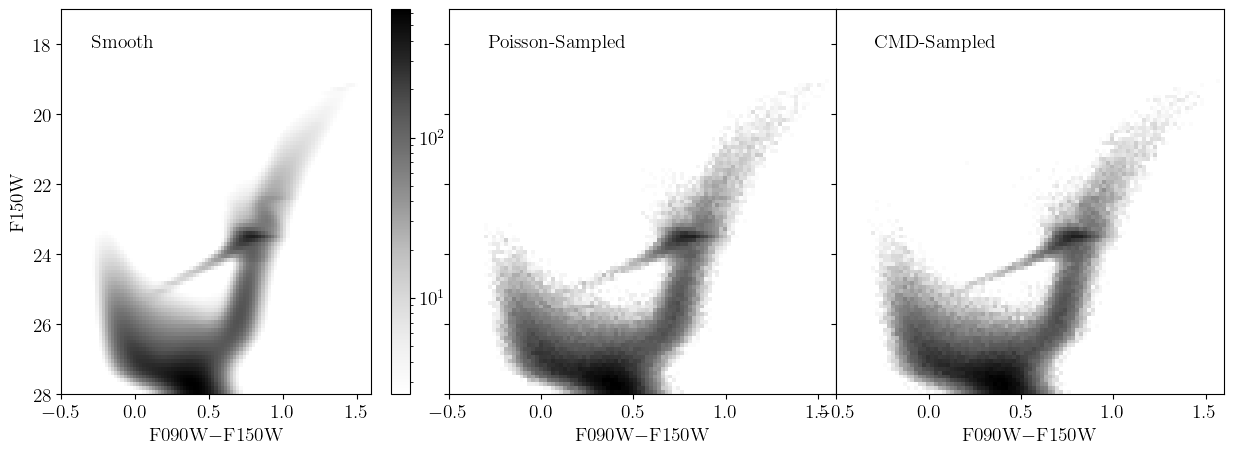

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5e3c02470>

In [32]:
fig,axs=plt.subplots(nrows=1,ncols=3,sharex=true,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[3].imshow(permutedims(model4), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true, label="CMD-Sampled") 
axs[3].text(0.1,0.9,"CMD-Sampled",transform=axs[3].transAxes)

axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1)

The mock Hess diagram created by Poisson-sampling the smooth model (labelled "Poisson-Sampled") and the Hess diagram created by sampling stars via `generate_stars_mass_composite` and mock observing them with `model_cmd` (labelled "CMD-Sampled") are highly consistent. The Poisson-sampled method is more efficient if a Hess diagram is all that is required, but if you need individual stars (e.g., for forming a star catalog for injection into images) then you should go the CMD-sampled route.

## SFH Fitting: Per-Template Coefficients

We will now explore the methods offered to fit SFHs. We will adopt the Poisson-sampled model Hess diagram above for this purpose.

In [33]:
data = model3

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

The best way to fit this SFH would be to use `fit_templates_mdf` as it uses the same hierarchical model as we used to generate the SFH (fitting stellar masses per bin in logage, and a mean metallicity relation with Gaussian scatter). We will first show how to use some of the simpler fitting methods that fit per-template stellar masses. These methods are generally most useful when you have a smaller set of templates that you want to use to fit the SFH. For this purpose, we will create a smaller grid of templates centered around a reasonable (but not exactly correct) metallicity evolution; we will accept any isochrone within ± 0.2 dex of this metallicity evolution guess.

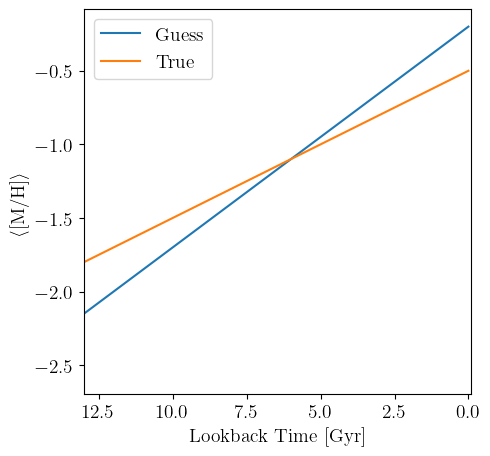

PyObject <matplotlib.legend.Legend object at 0x7fd5e1754100>

In [34]:
new_α, new_β, new_σ = -0.15, -0.2, 0.2
met_func(logAge) = exp10(logAge) * new_α / 1e9 + new_β
met_func_true(logAge) = exp10(logAge) * α / 1e9 + β
laxplot = 6.6:0.01:10.2
fig,ax1=plt.subplots()
ax1.plot(exp10.(laxplot)./1e9, met_func.(laxplot),label="Guess")
ax1.plot(exp10.(laxplot)./1e9, met_func_true.(laxplot),label="True")
ax1.set_xlim([13.0,-0.1])
ax1.set_xlabel("Lookback Time [Gyr]")
ax1.set_ylabel(L"$\langle$[M/H]$\rangle$")
ax1.legend(loc="upper left")

Now create the limited template set.

In [35]:
free_templates = Vector{Matrix{Float64}}(undef,0)
free_template_logAge = Vector{Float64}(undef,0)
free_template_MH = Vector{Float64}(undef,0)
for logage in unique_logAge
    mean_met = met_func(logage)
    for mh in unique_MH
        # If the current mh is more than `new_σ` dex away from mean, skip template
        abs(mh - mean_met) > new_σ && continue
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last star because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1]
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]]
        push!(free_templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(free_template_logAge, logage)
        push!(free_template_MH, mh)
    end
end

In [36]:
# `templates` has 1846 entries, free_templates has ~10% of that.
length(free_templates)

284

Let's start off by just obtaining the maximum likelihood estimate (MLE) via `fit_templates_lbfgsb`. We'll construct the initial guess vector `x0` with `construct_x0`.

In [37]:
import StarFormationHistories: fit_templates_lbfgsb, construct_x0
lbfgsb_result = fit_templates_lbfgsb(free_templates, data; x0=construct_x0(free_template_logAge, max_logAge; normalize_value=template_norm))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          284     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  284   5692   5696   5979     0   208   9.982D-06   1.216D+04

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Total User time 8.865E+00 seconds.



(12156.04045106269, [1.3432521886842699, 0.0, 0.0, 3.4806032047965627, 0.0, 0.0, 0.0, 0.5878807033114457, 0.222830689724101, 0.0  …  350.98764250227424, 537.4369513948491, 101.98770092053056, 99.96072174256993, 196.52278800592464, 448.3690642678708, 546.4555334068633, 0.0, 237.6660169445516, 440.8793647515721])

In [38]:
free_coeffs = lbfgsb_result[2] .* template_norm
unique_free_template_logAge, free_cum_sfr_arr, free_sfr_arr, free_mean_mh_arr = calculate_cum_sfr(free_coeffs, free_template_logAge, max_logAge, free_template_MH)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [1.0, 0.9995156615011559, 0.9994566354246848, 0.9994342621417079, 0.9994342621417079, 0.9994342621417079, 0.9994342621417079, 0.9994342621417079, 0.9994342621417079, 0.9994113141465105  …  0.6522958989772267, 0.6522958989772267, 0.6522958989772267, 0.5619701992620147, 0.5449580643294818, 0.523749690063683, 0.433003928867516, 0.2972250552761866, 0.20802291320413024, 0.12299603862617645], [0.009930446160596601, 0.00107860812119678, 0.0003643757662465889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018731153379727356, 0.0  …  0.0, 0.0, 0.0013110555831731957, 0.00022007392465736564, 0.0002445215547900665, 0.0009324726825937341, 0.0012434890670976486, 0.0007280899782600083, 0.0006185374296932246, 0.0011031512411351974], [-0.18353808805087313, -0.1, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4  …  -0.6, -0.6, -1.1692458382798336, -1.3, -1.4, -1.2, -1.46

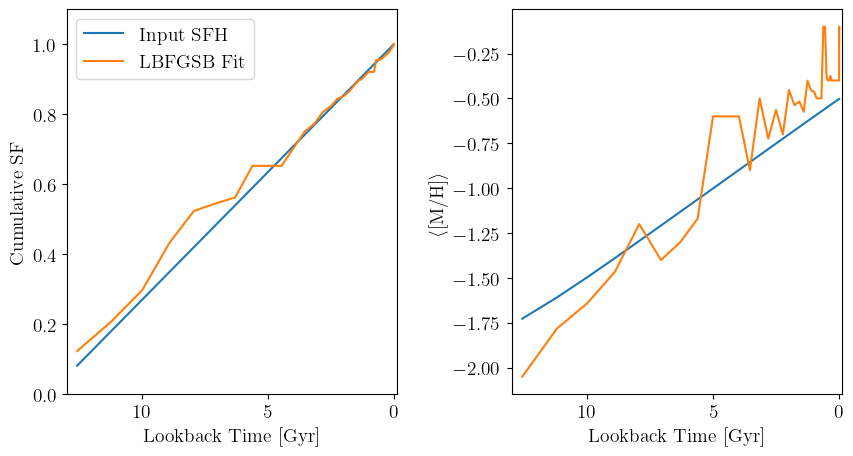

PyObject Text(447.8810729977773, 0.5, '$\\langle$[M/H]$\\rangle$')

In [39]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, free_cum_sfr_arr, label="LBFGSB Fit" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="LBFGSB Fit" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

We can also use `fit_templates`, which uses BFGS to build a dense estimate of the inverse Hessian. This function has worse scaling with the number of templates than `fit_templates_lbfgsb` above, but allows for estimation of random uncertainties.

In [40]:
import LinearAlgebra: BLAS
BLAS.set_num_threads(1) # BFGS uses BLAS operations, but they are relatively small so it's actually more efficient to run BLAS single-threaded.
import StarFormationHistories: fit_templates
bfgs_result = fit_templates(free_templates, data; x0=construct_x0(free_template_logAge, max_logAge; normalize_value=template_norm))

(map = (μ = [0.33069665526124464, 0.3151001588200285, 0.5082888374735895, 1.6719870043691802, 0.25532740315030616, 0.21742454699866096, 0.22735668316080665, 0.5893489469880073, 0.2632595919943841, 0.18636134504523555  …  332.5616823910808, 546.5410763218997, 106.3560818157419, 107.36112135673382, 203.71095680543146, 436.2993449330352, 511.2332355544774, 31.723704629541412, 210.91747704427976, 443.7613417314983], σ = [0.3198237545613038, 0.3082986983937671, 0.48674458612568217, 0.7313542509378398, 0.2507913945193003, 0.21499554170804777, 0.22517718998013397, 0.4075030927160218, 0.2590196740258271, 0.18486889270174828  …  43.42632075179458, 55.13348035764554, 31.259871855033893, 30.702012496076012, 36.958124982170915, 51.91912029440076, 90.99452236338068, 29.429322702422496, 77.1989776954223, 68.99315118807067], invH = [0.9353234651419077 -0.051352224904642335 … -0.0021325898121879894 -0.0010406710548419389; -0.05135222490464235 0.9572957662972854 … -0.002075902564250948 -0.0006204063744

`bfgs_result.mle` contains information for the maximum likelihood estimate; this is most similar to what is returned by `fit_templates_lbfgsb` but not exactly equal.

In [41]:
bfgs_result.mle.μ .- lbfgsb_result[2]

284-element Vector{Float64}:
  5.505005464079282e-5
  4.088121494264851e-99
  1.672337958911484e-103
 -2.4860802287918204e-5
  4.6256743652297516e-60
  6.148564318673497e-128
  6.739485216517423e-155
  3.1243847408157777e-6
 -4.932621127701209e-5
  7.919310348384588e-141
  1.4695400377719682e-178
  1.72114279986542e-191
  4.485172905008358e-80
  ⋮
  3.356899436384654e-177
  1.456457736455085e-58
 -0.0026395428523642295
  0.00580421003758147
  0.0012034219156760173
 -0.00015481676727802096
 -0.001047959284846911
  0.0011714126267747815
  0.034493577958187416
  4.74559505125269e-88
 -0.01775236994726015
 -0.006991812661055974

Of additional note are the uncertainty estimates, available as `bfgs_result.map.σ` and `bfgs_result.mle.σ`. The `bfgs_result.map` result contains the maximum a posteriori result and is often very comparable to the results of posterior sampling via Hamiltonian Monte Carlo provided by `hmc_sample`. We don't generally recommend the use of `bfgs_result.mle.σ`, but provide it for completeness.

In [42]:
bfgs_result.map.μ

284-element Vector{Float64}:
   0.33069665526124464
   0.3151001588200285
   0.5082888374735895
   1.6719870043691802
   0.25532740315030616
   0.21742454699866096
   0.22735668316080665
   0.5893489469880073
   0.2632595919943841
   0.18636134504523555
   0.16126001972012705
   0.16312718419961705
   0.2202467963886107
   ⋮
   6.48726040654995
  29.37404387346945
 332.5616823910808
 546.5410763218997
 106.3560818157419
 107.36112135673382
 203.71095680543146
 436.2993449330352
 511.2332355544774
  31.723704629541412
 210.91747704427976
 443.7613417314983

In [43]:
bfgs_result.map.σ

284-element Vector{Float64}:
  0.3198237545613038
  0.3082986983937671
  0.48674458612568217
  0.7313542509378398
  0.2507913945193003
  0.21499554170804777
  0.22517718998013397
  0.4075030927160218
  0.2590196740258271
  0.18486889270174828
  0.16033948999788214
  0.16229015199078556
  0.21804612324477277
  ⋮
  6.4832052732753755
 24.47340898774977
 43.42632075179458
 55.13348035764554
 31.259871855033893
 30.702012496076012
 36.958124982170915
 51.91912029440076
 90.99452236338068
 29.429322702422496
 77.1989776954223
 68.99315118807067

### Sampling from Inverse Hessian

Another thing we can do is draw samples from the posterior approximating the posterior distribution as Gaussians and the inverse Hessian as its variance-covariance matrix. There are additional notes in the documentation on this approximation, but it often reproduces results from more expensive Monte Carlo sampling methods fairly well. In short, we are approximating the posterior (in the transformed fitting variables `θ = log(coeffs)`) as a multivariate Gaussian in the region of the MAP estimate. For a multivariate Gaussian, the inverse of the Hessian matrix (which the BFGS algorithm from Optim.jl computes for us) is an estimator for the variance-covariance matrix. In concert with the MAP estimate for the parameters, this gives us both the means μ and the variance-covariance matrix Σ needed to define our multivariate Gaussian approximation of the posterior, which we can then sample from using `MvNormal` from Distributions.jl.

In [44]:
import Distributions: MvNormal # multivariate normal distribution
import Optim
import LinearAlgebra: Hermitian 
import Statistics: mean, median, quantile

# Generate sample from the inverse Hessian matrix
hessian_dist = MvNormal(Optim.minimizer(bfgs_result.map.result),
                        Hermitian(bfgs_result.map.invH))
hessian_sample = exp.(rand(hessian_dist, 10000)) .* template_norm
# Calculate the cumulative SFH for each sample
# and find the 1-σ quantile range for both the cumulative SFH and the SFRs
hessian_cum_sfr = Vector{Vector{Float64}}(undef,0)
hessian_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(hessian_sample)
    _, hessian_1, hessian_2, hessian_mh = calculate_cum_sfr(x, free_template_logAge, max_logAge, free_template_MH)
    push!(hessian_cum_sfr, hessian_1)
    push!(hessian_sfr, hessian_2)
end
hessian_cum_sfr = reduce(hcat, hessian_cum_sfr) 
hessian_sfr = reduce(hcat, hessian_sfr) 
# Now calculate quantiles
hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
hessian_cum_med = median.(eachrow(hessian_cum_sfr))
hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_lower = quantile.(eachrow(hessian_sfr), 0.16)
hessian_sfr_med = median.(eachrow(hessian_sfr))
hessian_sfr_upper = quantile.(eachrow(hessian_sfr), 0.84)

71-element Vector{Float64}:
 0.009747448194903944
 0.004935548768511243
 0.0030092375160290265
 0.002464142368745221
 0.00213973541721276
 0.0018559260748681767
 0.001533571086100601
 0.0013264255473550944
 0.0011537816738644278
 0.0008723391765975218
 0.0007749408914084613
 0.0007946102906038117
 0.001176204417166972
 ⋮
 0.0010847741843189962
 0.0010710240160248783
 0.00016136072663793124
 0.00030645812765602926
 0.001263842220035401
 0.0006260956734875882
 0.0004232300644539025
 0.0010402738200088807
 0.0013854933595495304
 0.0008192345027739544
 0.0006880263759741018
 0.001192515210421769

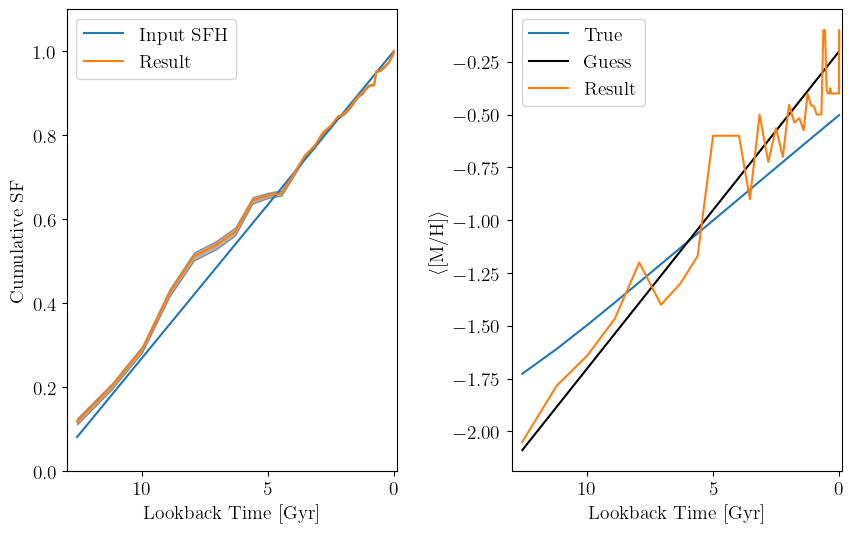

PyObject <matplotlib.legend.Legend object at 0x7fd5d419e710>

In [45]:
# Now plot cumulative SFH and MH evolution
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
# axs[1].plot( exp10.(unique_free_template_logAge)./1e9, cum_sfr_arr, label="Result" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="Result" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="True" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, met_func.(unique_template_logAge), c="k", label="Guess")
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="Result" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

We can additionally use the `Measurements.jl` package to estimate the uncertainties on the SFRs assuming that the `bfgs_result.map.σ` are Gaussian and *uncorrelated*.

In [46]:
import Measurements: uncertainty, ±
hessian_sfrerr = uncertainty.(calculate_cum_sfr(bfgs_result.map.μ .± bfgs_result.map.σ,
                                                            free_template_logAge, max_logAge, free_template_MH; normalize_value=template_norm)[3]) .* 1e3

71-element Vector{Float64}:
 2.0265930195372923
 1.047382459116473
 0.6402744317503779
 0.5175252914025729
 0.45127118974009384
 0.3879817961167861
 0.3201568720915429
 0.27542587143413944
 0.24720616892030053
 0.18696550596795897
 0.16826536176802348
 0.18294496719197037
 0.34126273633715626
 ⋮
 0.07084023535347493
 0.07404426400574418
 0.03845066502462774
 0.07763514801362645
 0.13854663170321868
 0.15543497890729585
 0.09030773481775366
 0.09503599171055674
 0.17901120585267086
 0.061144386194628086
 0.05648874870077143
 0.1269263963054962

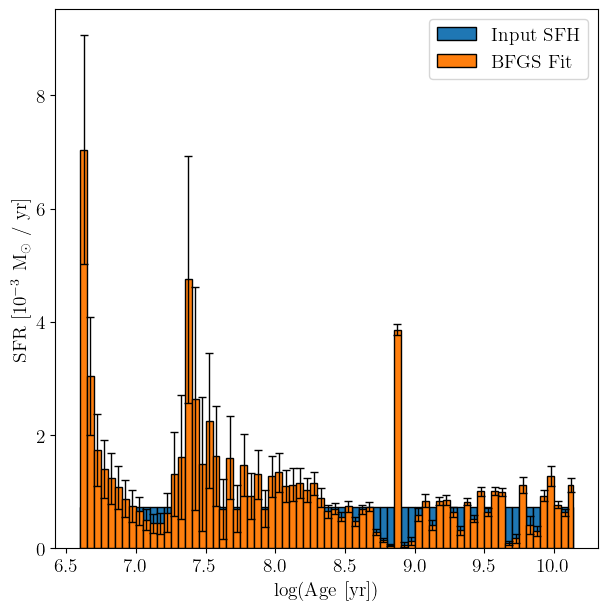

PyObject <matplotlib.legend.Legend object at 0x7fd6804132e0>

In [47]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
# ax1.bar(unique_free_template_logAge[begin:end-1], free_sfr_arr[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", yerr = hessian_sfrerr[begin:end-1], capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="LBFGS Fit")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", yerr = hessian_sfrerr, capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

The random errors here are underestimating the true uncertainty because there is a systematic error in the a priori metallicity evolution model by design. 

If we make the same plot with the `hessian_sfr_lower` and `hessian_sfr_upper` vectors, which utilize the samples from the full variance-covariance matrix, we see that the uncertainties look very similar across most of the plot, but are not identical due to the inclusion of covariance between parameters.

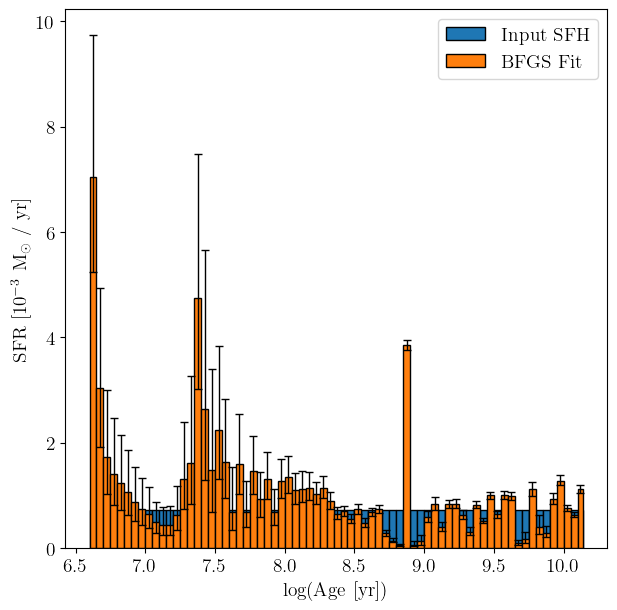

PyObject <matplotlib.legend.Legend object at 0x7fd6801ef6d0>

In [48]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

### Sampling via Hamiltonian Monte Carlo

Let us now compare to `hmc_sample`, which utilizes the No-U-Turn sampler variant of Hamiltonian Monte Carlo implemented in `DynamicHMC.jl` to sample from the posterior. This is a more rigorous way to obtain posterior samples than the method used above, but we will show that it gives very similar results.

In [49]:
import DynamicHMC
import StarFormationHistories: hmc_sample
mc_result = hmc_sample(free_templates, data, 1000; reporter=DynamicHMC.ProgressMeterReport());

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:59
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:27
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:24
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:33
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:47
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:10
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:10
MCMC: 100%|█████████████████████████████████████████████| Time: 0:02:16


We can check the summary statistics to ensure the samples have a high acceptance rate and are converging properly (turning % should be ~100%).

In [50]:
DynamicHMC.Diagnostics.summarize_tree_statistics(mc_result.tree_statistics)

Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.91, 5/25/50/75/95%: 0.72 0.87 0.94 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 100%

The parameters optimized by `full_templates` and `hmc_sample` are actually the logarithms of the coefficients, not the coefficients themselves, so we need to transform the samples here.

In [51]:
mc_matrix = exp.(mc_result.posterior_matrix) .* template_norm

284×1000 Matrix{Float64}:
    656.117        268.085      …      90.274         750.783
    631.594        293.979            110.787         896.808
   1546.74        1196.8              116.687         169.218
    421.273        988.039           3148.39          628.163
    153.137        417.001            315.416         176.256
     16.7949        66.2713     …      58.2005        245.029
     21.6131       396.824            209.173         202.34
    384.475       1146.12            1109.91          175.939
    326.02         192.524            130.028         452.281
     75.2221       398.596            376.701          24.7498
     28.7429       227.732      …      63.6971        122.266
     79.2243        42.6076           360.309          36.7517
    185.102        189.213             88.8578        521.947
      ⋮                         ⋱                  
   9270.52         606.916           2962.23         8838.55
  22830.8        11937.5             1557.55        80

Calculate statistics from the MC samples.

In [52]:
# Calculate the cumulative SFH for each sample in the chain
# and find the 1-σ range
mc_cum_sfr = Vector{Vector{Float64}}(undef,0)
mc_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mc_matrix)
    _, mc_1, mc_2, mc_mh = calculate_cum_sfr(x, free_template_logAge, max_logAge, free_template_MH)
    push!(mc_cum_sfr, mc_1)
    push!(mc_sfr, mc_2)
end
mc_cum_sfr = reduce(hcat, mc_cum_sfr) # hcat( mc_cum_sfr... )
mc_sfr = reduce(hcat, mc_sfr) # hcat( mc_sfr... )
# Calculate quantiles
mc_cum_lower = quantile.(eachrow(mc_cum_sfr), 0.16)
mc_cum_med = median.(eachrow(mc_cum_sfr))
mc_cum_upper = quantile.(eachrow(mc_cum_sfr), 0.84)
mc_sfr_lower = quantile.(eachrow(mc_sfr), 0.16)
mc_sfr_med = median.(eachrow(mc_sfr))
mc_sfr_upper = quantile.(eachrow(mc_sfr), 0.84)

71-element Vector{Float64}:
 0.007318312476437124
 0.003361490815910448
 0.0018592871111343182
 0.0015270344947752343
 0.001308695406203976
 0.0011158152580186414
 0.0009588330782795681
 0.0007774383746569929
 0.0006911617800054011
 0.0005470493464055773
 0.0004814354908427568
 0.0005035541958577179
 0.0008103207535449011
 ⋮
 0.0010661170457111299
 0.0010641089735732385
 0.0001117922523031147
 0.00019621069502955978
 0.0012233007252330486
 0.0005533525984151488
 0.0003472813141101911
 0.0009979730377148465
 0.0012913014227134124
 0.0008003410972897999
 0.0006677346568124969
 0.0011595742145724956

And we'll plot the cumulative SFHs:

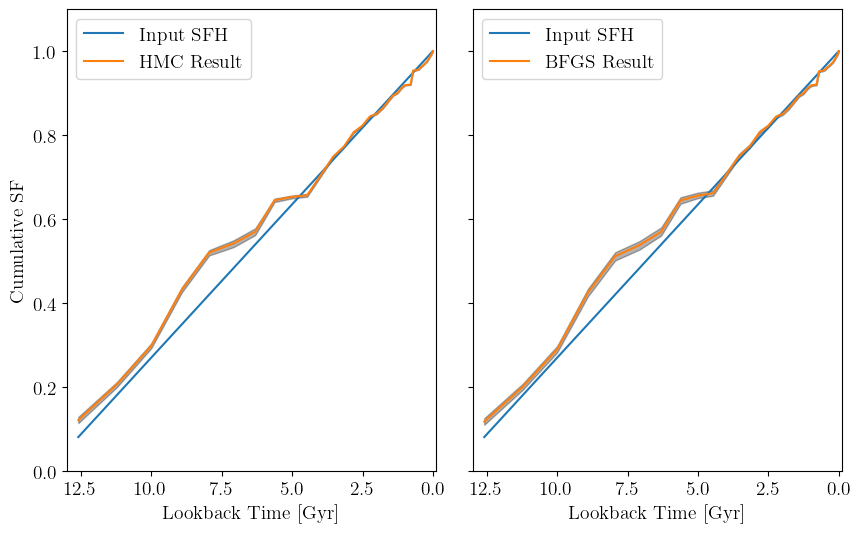

PyObject <matplotlib.legend.Legend object at 0x7fd5d40ff880>

In [53]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, mc_cum_med, label="HMC Result" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, mc_cum_lower, mc_cum_upper, alpha=0.3, fc="k") 

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="BFGS Result" )
axs[2].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].legend()

The differences are more obvious in the SFRs,

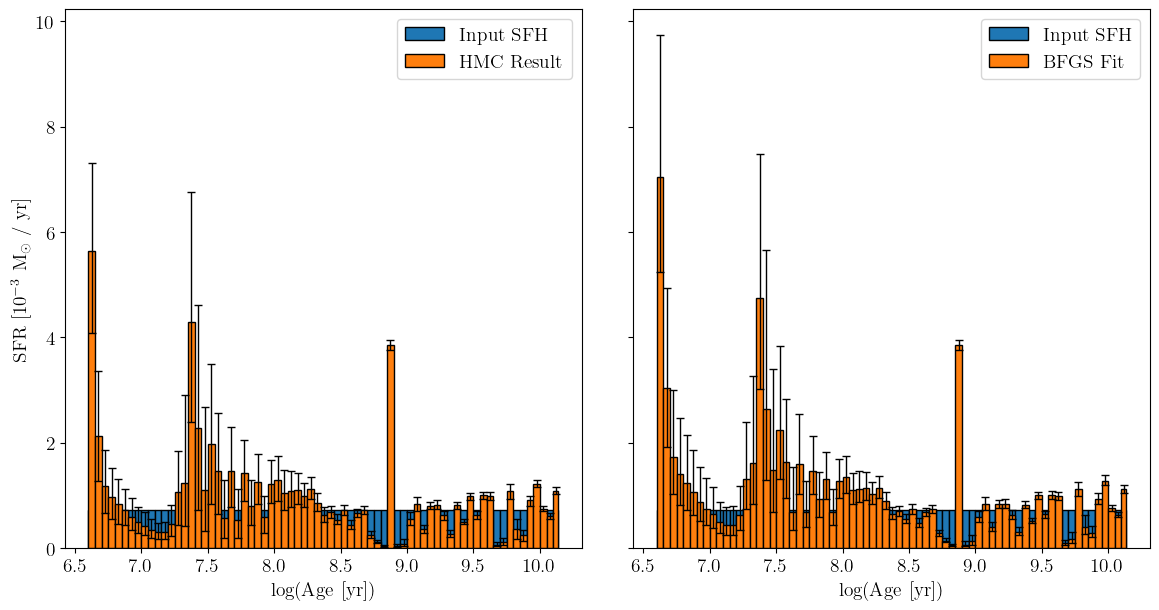

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [54]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mc_sfr_med .- mc_sfr_lower) .* 1e3, 
        (mc_sfr_upper .- mc_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="HMC Result")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, ax1.get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

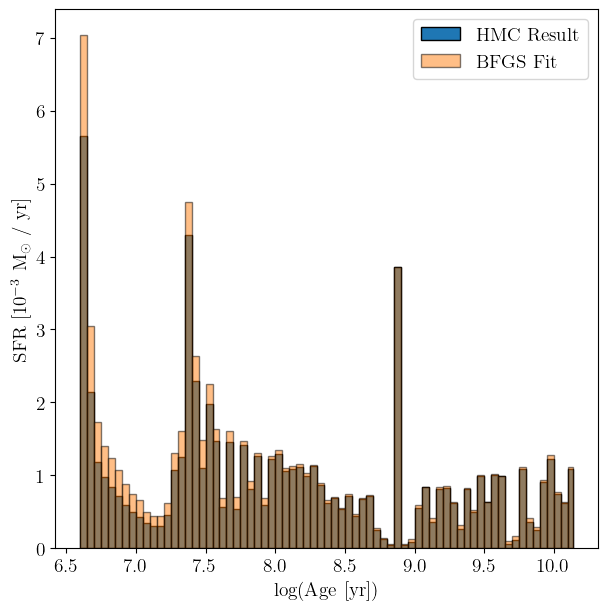

PyObject <matplotlib.legend.Legend object at 0x7fd571249210>

In [55]:
# _, _, tmp_sfr, _ = calculate_cum_sfr(bfgs_result.map.μ .* template_norm, free_template_logAge, free_template_MH)

fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="HMC Result")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
# ax1.bar(unique_free_template_logAge, tmp_sfr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 

ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Thus the approximations we made above when deriving the uncertainties from the BFGS results that 
1. the posterior is well-approximated by a multivariate Gaussian in the fitting variables `θ = log(coeffs)` and 
2. the inverse Hessian approximation produced by the BFGS optimization is a good estimate of the variance-covariance matrix of said Gaussian

are not fully correct, but they are good enough in most cases that they can produce very similar posterior samples to the full HMC analysis at a fraction of the computational cost (a few seconds compared to minutes or hours). 

### Normalizing Templates to SFR

Because we have normalized the templates to uniform stellar mass above, and not uniform star formation rate, the posterior is slightly biased to favor higher star formation rates at more recent times. This is because our isochrone grid is uniform in `log(age)` and not `age` directly -- we have not accounted for this non-uniform spacing. As such, our priors are uniform in stellar mass per template, and not star formation rate (which is more physical and would be preferred). The maxium likelihood estimate `mle.μ` is insensitive to this effect. We can fix this by normalizing the templates to a fixed star formation rate rather than a fixed stellar mass.

In [56]:
# Compute change in time [yr] between bins of logAge
# diff(vcat(unique_template_logAge,max_logAge))
free_template_δt = diff(vcat(exp10.(unique_free_template_logAge), exp10(max_logAge)))

71-element Vector{Float64}:
 485764.21597466525
 545036.4147630902
 611540.9156307662
 686160.1928984392
 769884.3990394427
 863824.503401449
 969227.0340946363
      1.0874906186625417e6
      1.22018454301963e6
      1.3690695749220327e6
      1.5361213282858916e6
      1.7235564783835877e6
      1.9338621757780854e6
      ⋮
      4.3294778207552767e8
      4.8577540123786354e8
      5.450489648348255e8
      6.115549970428333e8
      6.861759925026665e8
      7.699021264869289e8
      8.638443939246902e8
      9.692493516287975e8
      1.0875156593476849e9
      1.2202126391305141e9
      1.3691010992768898e9
      1.1104560004323616e9

In [57]:
sfr_norm = 1e-3 # Star formation rate in solar masses / yr to normalize templates to
# SFR = stellar mass / dt; sfr_norm = A * template_norm / dt; where A is a multiplicative constant
# since we originally normalized all the templates to contain stellar mass = `template_norm`
# Solve for A = sfr_norm * dt / template_norm
free_sfr_templates = deepcopy(free_templates)
for i in eachindex(free_sfr_templates)
    idx = findfirst(==(free_template_logAge[i]), unique_free_template_logAge)
    A = sfr_norm * free_template_δt[idx] / template_norm
    free_sfr_templates[i] .*= A
end 

In [58]:
# And now fit
sfr_result = fit_templates(free_sfr_templates, data; x0=ones(length(free_sfr_templates)))

(map = (μ = [0.6807760781571147, 0.648668942322845, 1.0463694397739698, 3.4419724111662133, 0.4684593512912323, 0.39891747364300995, 0.4171403579673035, 1.081301963675601, 0.43048565945243655, 0.3047406016259559  …  0.2725440383691513, 0.4479064198746173, 0.07768314962203976, 0.0784172357158937, 0.14879175917721812, 0.3186757702845942, 0.460381342810704, 0.028568179425905137, 0.18993771804656417, 0.3996208202666876], σ = [0.6588284284245124, 0.6316911749622834, 0.9872536883728388, 1.5016839044634798, 0.46051409312968167, 0.3941656942352845, 0.41166849182050147, 0.7464958115844583, 0.42353570783076866, 0.30204081820547524  …  0.03542558693618472, 0.043748131147406305, 0.021826284299550015, 0.021110879229403284, 0.02584960190336772, 0.037121691858813546, 0.08104001760852218, 0.027515737432325788, 0.07133417556310463, 0.06032165055386995], invH = [0.936561041092728 -0.0541452254943714 … -0.0008541906649539171 -0.0004975135254220045; -0.0541452254943714 0.9483385601356885 … -0.000488081224

Since we know that the templates were normalized to uniform star formation rate of `sfr_norm`, the coefficients are now star formation rates and we can plot them directly. 

In [59]:
# Sum the SFRs of all templates with same logAge but different metallicities
sfr_norm_arr = similar(unique_free_template_logAge)
sfr_norm_arr_err = similar(unique_free_template_logAge)
for i in eachindex(unique_free_template_logAge)
    idxs = findall(==(unique_free_template_logAge[i]), free_template_logAge)
    sfr_norm_arr[i] = sum( sfr_result.map.μ[idxs] ) * sfr_norm
    sfr_norm_arr_err[i] = sqrt(sum( sfr_result.map.σ[idxs].^2 )) * sfr_norm
end
sfr_norm_arr .± sfr_norm_arr_err

71-element Vector{Measurements.Measurement{Float64}}:
   0.0058 ± 0.002
   0.0024 ± 0.001
  0.00127 ± 0.00064
  0.00103 ± 0.00052
  0.00089 ± 0.00045
  0.00077 ± 0.00039
  0.00063 ± 0.00032
  0.00054 ± 0.00027
  0.00048 ± 0.00024
  0.00036 ± 0.00019
  0.00032 ± 0.00017
  0.00033 ± 0.00018
  0.00052 ± 0.00034
          ⋮
    0.001 ± 6.9e-5
 0.000978 ± 7.3e-5
   7.1e-5 ± 3.6e-5
 0.000136 ± 7.3e-5
  0.00108 ± 0.00014
  0.00037 ± 0.00016
  0.00026 ± 9.2e-5
 0.000896 ± 9.1e-5
  0.00123 ± 0.00016
  0.00075 ± 5.9e-5
 0.000624 ± 5.4e-5
  0.00108 ± 0.00013

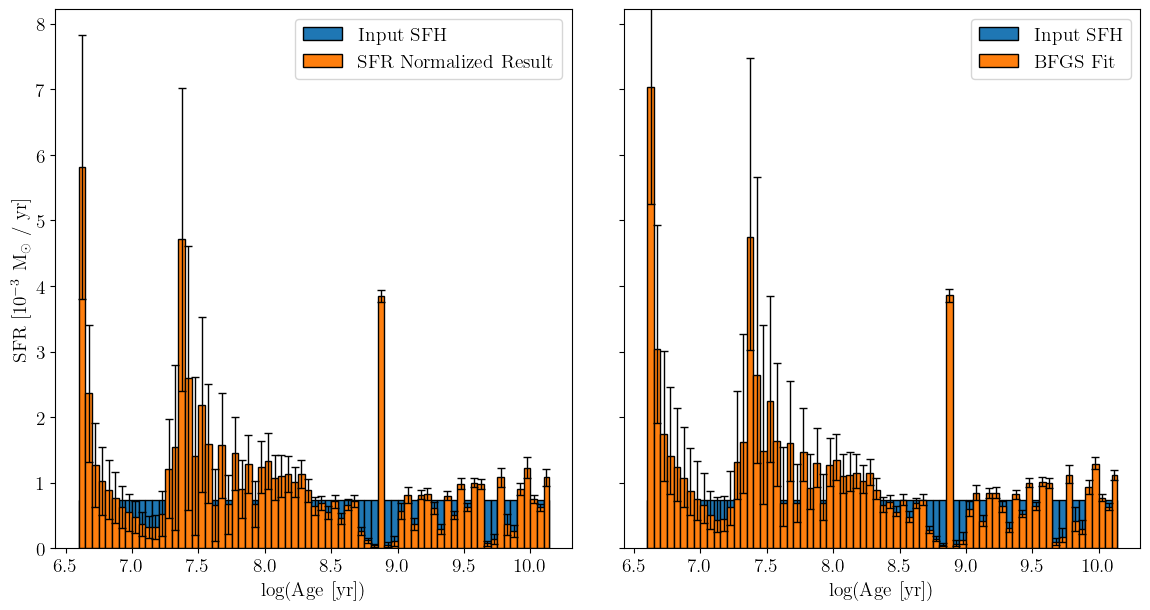

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [60]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = sfr_norm_arr_err .* 1e3, 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

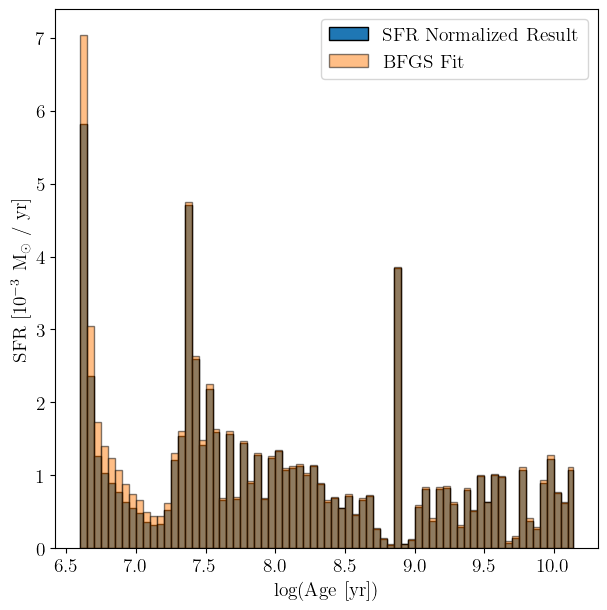

PyObject <matplotlib.legend.Legend object at 0x7fd570c3ce80>

In [61]:
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="SFR Normalized Result")
    # yerr = sfr_norm_arr_err .* 1e3, 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
    # yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
    #         (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit", alpha=0.7)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

You can see that the histograms labelled "BFGS Fit", for which the templates were normalized to uniform stellar mass, favor more star formation prior to `logAge ~ 7`. There is less star formation in this period in the histograms labelled "SFR Normalized Result", where we have normalized the templates to uniform star formation rate. This difference is small enough that it is not easily noticable in plots of cumulative SFH, but significant enough that you should be normalizing your templates to uniform star formation rate for publication-quality results.

In [62]:
# Generate sample from the inverse Hessian matrix
sfr_hessian_dist = MvNormal(Optim.minimizer(sfr_result.map.result),
                        Hermitian(sfr_result.map.invH))
sfr_hessian_sample = exp.(rand(sfr_hessian_dist, 10000)) .* sfr_norm
hessian_sfr_norm = Matrix{Float64}(undef,length(unique_free_template_logAge),size(sfr_hessian_sample,2))
for i in eachindex(unique_free_template_logAge)
    idxs = findall(==(unique_free_template_logAge[i]), free_template_logAge)
    hessian_sfr_norm[i,:] .= vec(sum( @view sfr_hessian_sample[idxs,:]; dims=1))
end

# Now calculate quantiles
# hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
# hessian_cum_med = median.(eachrow(hessian_cum_sfr))
# hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_norm_lower = quantile.(eachrow(hessian_sfr_norm), 0.16)
hessian_sfr_norm_med = median.(eachrow(hessian_sfr_norm))
hessian_sfr_norm_upper = quantile.(eachrow(hessian_sfr_norm), 0.84)

71-element Vector{Float64}:
 0.009611578927013692
 0.004874749478724745
 0.003050923490052191
 0.00244411342772075
 0.002147029060259218
 0.0018581424742693765
 0.0015411967546146703
 0.0013051630080101746
 0.0011477648666213102
 0.000869943352393434
 0.0007786696186919942
 0.0007962398411932536
 0.0012017186271308835
 ⋮
 0.0010797320343868288
 0.0010619237971304315
 0.00015552577434695692
 0.00029265070004707775
 0.0012608061027455915
 0.0006166075531550984
 0.000414430474632557
 0.0010295024440829016
 0.0013584142055754582
 0.0008152578555113302
 0.000684302774234529
 0.0011901463903520126

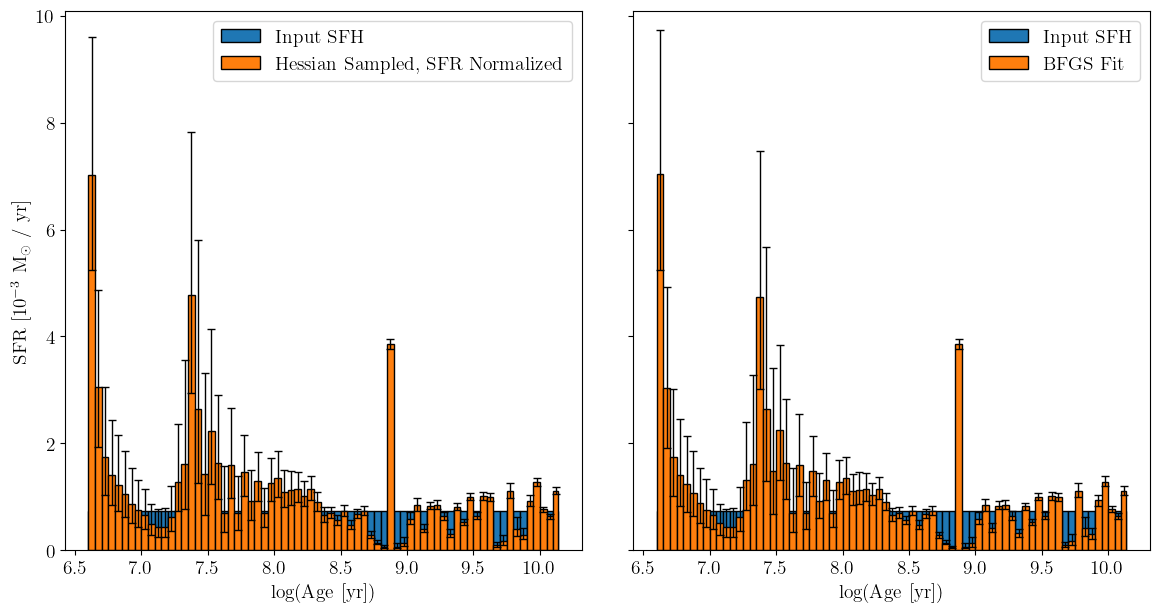

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [63]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_norm_med .- hessian_sfr_norm_lower) .* 1e3, 
            (hessian_sfr_norm_upper .- hessian_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Hessian Sampled, SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

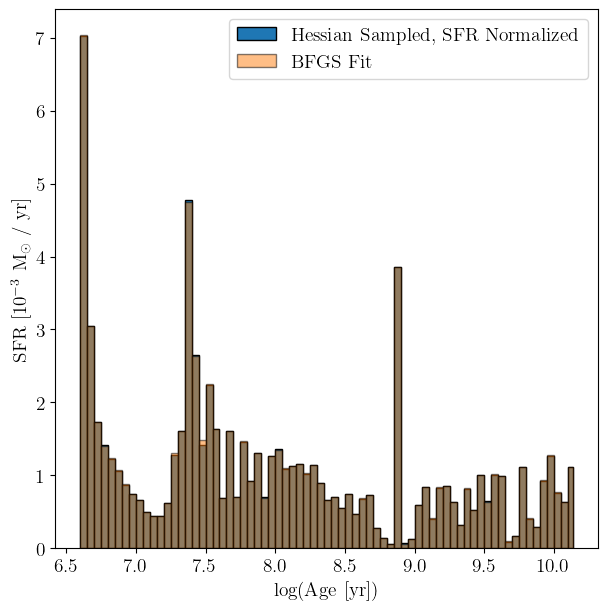

PyObject <matplotlib.legend.Legend object at 0x7fd570761c00>

In [64]:
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Hessian Sampled, SFR Normalized")
    # yerr = sfr_norm_arr_err .* 1e3, 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
    # yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
    #         (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit", alpha=0.7)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

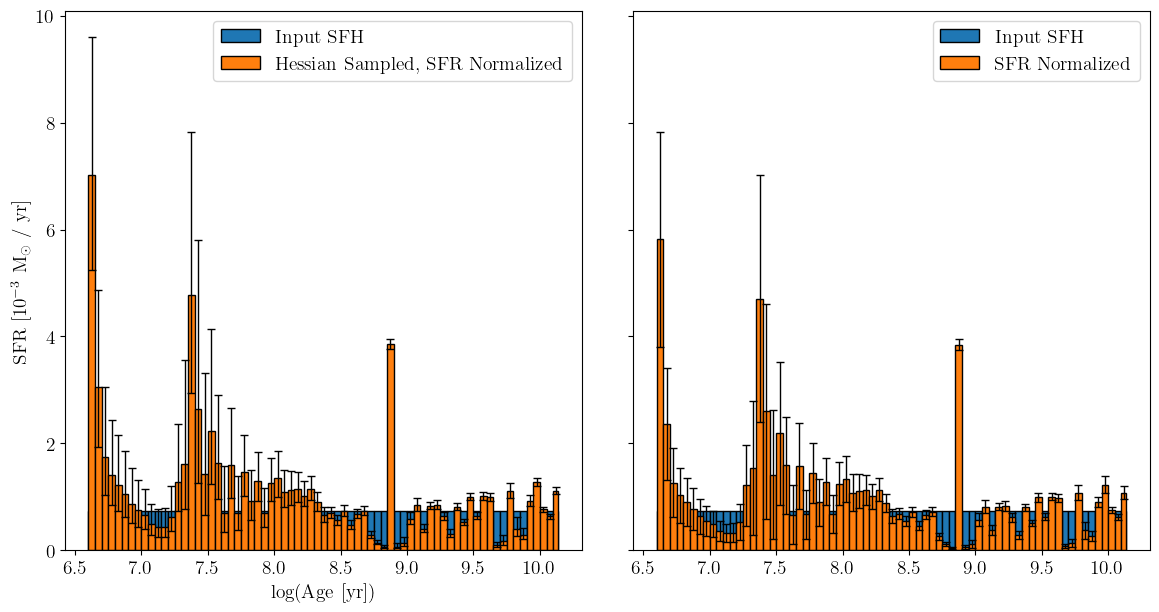

PyObject <matplotlib.legend.Legend object at 0x7fd5703d0730>

In [65]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_norm_med .- hessian_sfr_norm_lower) .* 1e3, 
            (hessian_sfr_norm_upper .- hessian_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Hessian Sampled, SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = sfr_norm_arr_err .* 1e3, 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized")
axs[2].legend()

## SFH Fitting: Constrained Metallicity Evolution

We will now use `fit_templates_mdf` to fit a constrained metallicity evolution model using the full template grid. This is the same approach we used to construct the model Hess diagram in the first place, so we expect to able to reproduce the true SFH fairly well. We will allow σ to be fit.

In [66]:
import StarFormationHistories: fit_templates_mdf
mdf_α, mdf_β, mdf_σ = -0.15, -0.2, 0.2 # initial guess for the metallicity evolution parameters
mdf_result = fit_templates_mdf(templates,
                                data,
                                template_logAge, template_MH;
                                x0=vcat(construct_x0_mdf(template_logAge, max_logAge; normalize_value=1e4),
                                        [mdf_α,mdf_β,mdf_σ]))

(map = (μ = [4.077047651484228, 2.1480239159239387, 1.6445291700432303, 1.3331215421442855, 1.1240231787200254, 1.039718290125251, 0.9769898362650283, 1.0954385837609282, 1.2283869006928336, 1.0839690390663517  …  618.5485971496048, 607.754773372894, 629.0790059046104, 750.8260087270058, 1267.262629102532, 521.8940112118302, 949.5581152318376, -0.10257242543833188, -0.4919598119865556, 0.3106926833693121], σ = [2.1057047107582636, 1.9684061971496662, 1.5600830134926233, 1.2732993517016675, 1.0801485149950203, 1.0046175093972884, 0.9524628738989805, 1.051156025141787, 1.1356611559880534, 1.037672824798816  …  439.3466344113675, 362.6068586381819, 419.07256053458036, 358.5379492327385, 289.11578418473016, 263.25021646139214, 142.60080566563005, 0.0008368944327334362, 0.003211895475151671, 0.002500774033100801], result =  * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.558564e+03

 * Found with
    Algorithm:     BFGS

 * 

We will now calculate the per-template coefficients using `calculate_coeffs_mdf`, which we can then use like the outfits of `fit_templates` for other methods like `calculate_cum_sfr`.

In [67]:
mdf_coeffs = calculate_coeffs_mdf(mdf_result.map.μ, template_logAge, template_MH)
mdf_coeffs *= template_norm
            
_, mdf_cum_sfr_arr, mdf_sfr_arr, mdf_mean_mh_arr =
    calculate_cum_sfr(mdf_coeffs, template_logAge, max_logAge, template_MH)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [1.0, 0.9995919571480961, 0.999376976632896, 0.9992123873442867, 0.99907896464176, 0.9989664691149334, 0.998862411067899, 0.9987646310679705, 0.9986549963710003, 0.9985320558176767  …  0.6736132625253178, 0.6406691856968623, 0.5908421996179865, 0.5349355386475123, 0.47302938615744433, 0.4122035111164744, 0.3492434445230131, 0.27409858184939984, 0.14726723193816357, 0.09503455306601577], [0.008393058849145166, 0.003941064959591031, 0.0026891564047632063, 0.0019428721688342027, 0.0014599895518371707, 0.001203622131614919, 0.0010080092711999549, 0.0010073085367009065, 0.0010067222271582827, 0.0007917559917494208  …  0.0006039233703238935, 0.0008140837998580438, 0.0008140818059261825, 0.0008034119868872789, 0.0007035465850645756, 0.0006490373244485126, 0.0006904047792538153, 0.0010385588449612717, 0.0003811946477053271, 0.0008551064741530

### Sampling from Inverse Hessian 

We'll now draw samples from the posterior using the same approximation techinque as we did in the previous section.

In [68]:
mdf_dist = MvNormal(Optim.minimizer(mdf_result.map.result),
                    Hermitian(Optim.trace(mdf_result.map.result)[end].metadata["~inv(H)"]))
mdf_sample = rand(mdf_dist, 10000)
# Transform the variables, noting that the stellar mass coefficients `mdf_sample[begin:end-3,:]` 
# and σ `mdf_sample[end,:]` are fit with logarithmic transformations so we have to transform them back.
# α and β are optimized directly, without a transformation.
@views mdf_sample[begin:end-3,:] .= exp.(mdf_sample[begin:end-3,:]) .* template_norm
@views mdf_sample[end,:] .= exp.(mdf_sample[end,:])
# Calculate the cumulative SFH for each point in the sample
# and find the 1-σ range
mdf_cum_sfr = Vector{Vector{Float64}}(undef,0)
mdf_sfr = Vector{Vector{Float64}}(undef,0)
mdf_mh = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mdf_sample)
    tmp_coeffs = calculate_coeffs_mdf(x, template_logAge, template_MH)
    _, mdf_1, mdf_2, mdf_3 = calculate_cum_sfr(tmp_coeffs, template_logAge, max_logAge, template_MH)
    push!(mdf_cum_sfr, mdf_1)
    push!(mdf_sfr, mdf_2)
    push!(mdf_mh, mdf_3)
end
mdf_cum_sfr = reduce(hcat, mdf_cum_sfr) 
mdf_sfr = reduce(hcat, mdf_sfr) 
mdf_mh = reduce(hcat, mdf_mh) 

# Now calculate quantiles
mdf_cum_lower = quantile.(eachrow(mdf_cum_sfr), 0.16)
mdf_cum_med = median.(eachrow(mdf_cum_sfr))
mdf_cum_upper = quantile.(eachrow(mdf_cum_sfr), 0.84)
mdf_sfr_lower = quantile.(eachrow(mdf_sfr), 0.16)
mdf_sfr_med = median.(eachrow(mdf_sfr))
mdf_sfr_upper = quantile.(eachrow(mdf_sfr), 0.84)
mdf_mh_lower = quantile.(eachrow(mdf_mh), 0.16)
mdf_mh_med = median.(eachrow(mdf_mh))
mdf_mh_upper = quantile.(eachrow(mdf_mh), 0.84);

We can look at the marginal distribution of the metallicity variables

In [69]:
println((α, β, σ))
mdf_sample[end-2:end,:]

(-0.1, -0.5, 0.3)


3×10000 Matrix{Float64}:
 -0.102     -0.102785  -0.101209  …  -0.102323  -0.102818  -0.102613
 -0.495556  -0.488756  -0.492471     -0.491667  -0.491929  -0.493196
  0.310574   0.312127   0.307241      0.311089   0.315448   0.311816

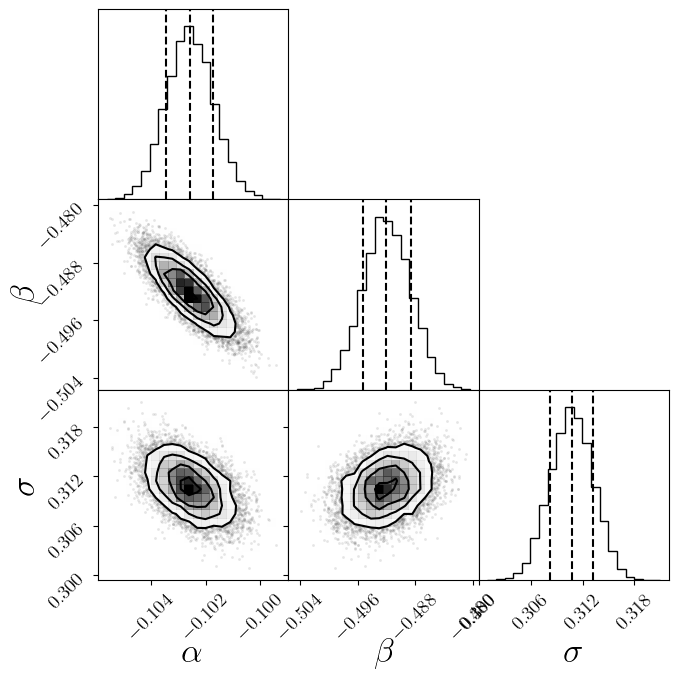

In [70]:
@pyimport corner # Easy marginal distributions
fig=plt.figure(figsize=(7,7))
# fig.suptitle("Linear M/H")
corner.corner( permutedims(@view mdf_sample[end-2:end,:]),
                fig=fig,
                labels=[L"\alpha", L"\beta", L"\sigma"],
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=4,
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

We see that the inverse Hessian has captured some covariance between the parameters. Now we'll plot the cumulative SFH and metallicity evolution.

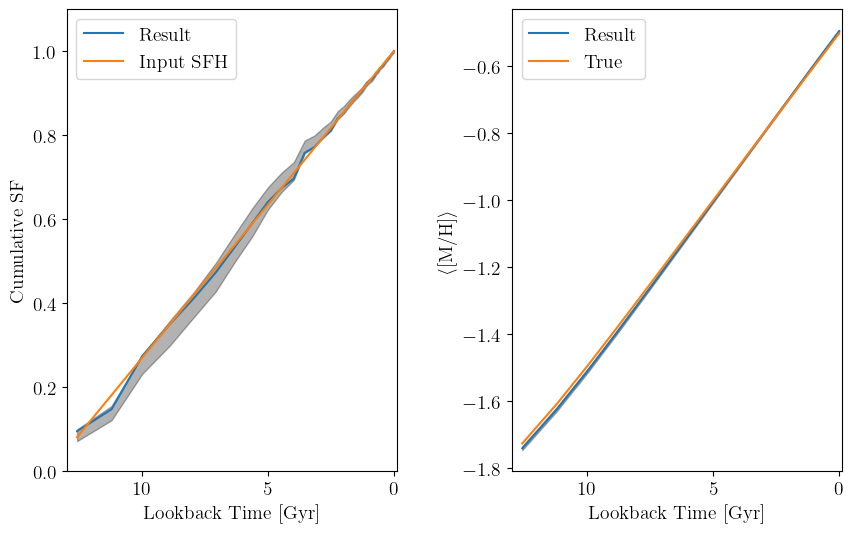

PyObject <matplotlib.legend.Legend object at 0x7fd5684f3f70>

In [71]:
# Now plot cumulative SFH and MH evolution for the metallicity evolution model
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, mdf_cum_sfr_arr, label="Result" ) # This is MAP result
# axs[1].plot( exp10.(unique_template_logAge)./1e9, mdf_cum_med, label="Result" ) # This is median of samples
axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].fill_between( exp10.(unique_template_logAge)./1e9, mdf_cum_lower, mdf_cum_upper, alpha=0.3, fc="k")

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mdf_mh_med, label="Result" )
axs[2].fill_between( exp10.(unique_template_logAge)./1e9, mdf_mh_lower, mdf_mh_upper, alpha=0.3, fc="k")
axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="True" )

axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

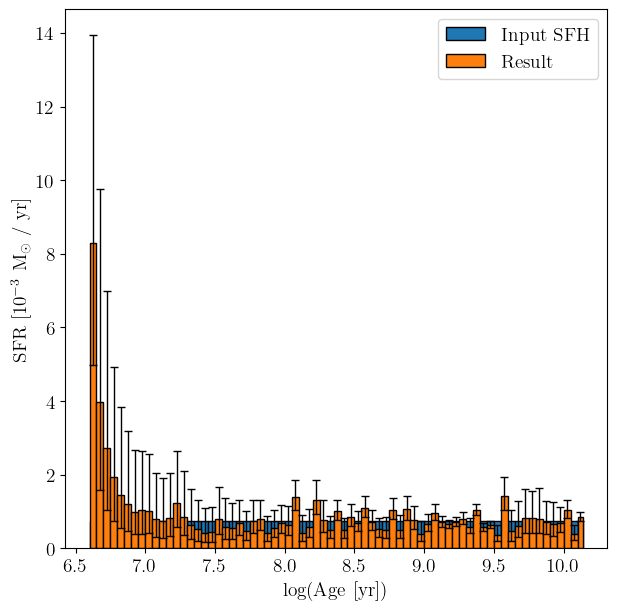

PyObject <matplotlib.legend.Legend object at 0x7fd56837c550>

In [72]:
# Now plot the SFRs for the metallicity evolution model
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# ax1.bar(unique_template_logAge, mdf_sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Result")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

The resulting fit is very consistent with the true values. We do, however, see that there is a slight bias for higher SFRs at recent times. This is a result of 
1. normalizing the templates to uniform stellar mass instead of uniform star formation rate, and
2. our isochrone grid being uniformly spaced in `log(age [yr])` and not simply `age`.

### Normalizing Templates to SFR

When we perform the maximum a posteriori optimization, we assume uniform priors on the multiplicative coefficients (these are the `R_j` in the documentation section "Constrained Metallicity Evolution"). We sampled each template with equal stellar mass, but they do not have all have equal width in the time domain as our isochrone grid is uniformly spaced in `log(age [yr])` and not simply `age`. As a result, the templates all have the same stellar mass, but they do not all have the same star formation rate due to this non-uniform time binning. As such our uniform priors on the coefficients `R_j` are *not* uniform in star formation rate. This results in a slight bias towards higher star formation rates at earlier times. 

In [73]:
# Compute change in time [yr] between bins of logAge
template_δt = diff(vcat(exp10.(unique_template_logAge), exp10(max_logAge)))
sfr_norm = 1e-3 # Star formation rate in solar masses / yr to normalize templates to
# Now normalize the templates:
# SFR = stellar mass / dt; sfr_norm = A * template_norm / dt; where A is a multiplicative constant
# since we originally normalized all the templates to contain stellar mass = `template_norm`
# Solve for A = sfr_norm * dt / template_norm
sfr_templates = deepcopy(templates)
for i in eachindex(sfr_templates)
    idx = findfirst(==(template_logAge[i]), unique_template_logAge)
    A = sfr_norm * template_δt[idx] / template_norm
    sfr_templates[i] .*= A
end 

In [74]:
# And now fit
mdf_sfr_result = fit_templates_mdf(sfr_templates, data, template_logAge, template_MH;
                                   x0=vcat(ones(length(unique_template_logAge)),
                                           [mdf_α,mdf_β,mdf_σ]))

(map = (μ = [8.393058849144865, 3.941064959591766, 2.689156404761377, 1.942872168832625, 1.4599895518360366, 1.203622131614351, 1.0080092711998792, 1.0073085367006827, 1.0067222271582388, 0.7917559917498589  …  0.8034119868859922, 0.7035465850655247, 0.6490373244480361, 0.6904047792538303, 1.0385588449615741, 0.3811946477051407, 0.855106474153127, -0.10257242543833214, -0.49195981198656147, 0.31069268336931377], σ = [4.284257598755013, 3.6284848561592615, 2.5439928098222766, 1.8629076261102082, 1.4123418236624008, 1.169216739918251, 0.9835220803945506, 0.9671545686316398, 0.9387359349005119, 0.7591440483099479  …  0.5486502585125039, 0.408715061143285, 0.42930734028030376, 0.330943990544818, 0.23827287323825388, 0.19036589809718515, 0.1281983097270178, 0.0008207921337998675, 0.003187329807543688, 0.002431111657127993], result =  * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.793073e+03

 * Found with
    Algorithm:    

In [75]:
# Generate sample from the inverse Hessian matrix
mdf_sfr_dist = MvNormal(Optim.minimizer(mdf_sfr_result.map.result),
                        Hermitian(Optim.trace(mdf_sfr_result.map.result)[end].metadata["~inv(H)"]))
mdf_sfr_sample = rand(mdf_sfr_dist, 10000)
# Transform the variables, noting that the SFR coefficients `mdf_sfr_sample[begin:end-3,:]` 
# and σ `mdf_sfr_sample[end,:]` are fit with logarithmic transformations so we have to transform them back.
# α and β are optimized directly, without a transformation.
@views mdf_sfr_sample[begin:end-3,:] .= exp.(mdf_sfr_sample[begin:end-3,:]) .* sfr_norm
@views mdf_sfr_sample[end,:] .= exp.(mdf_sfr_sample[end,:]);

In [76]:
# Now calculate quantiles
mdf_sfr_norm_lower = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.16)
mdf_sfr_norm_med = median.(eachrow(@view mdf_sfr_sample[begin:end-3,:]))
mdf_sfr_norm_upper = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.84);

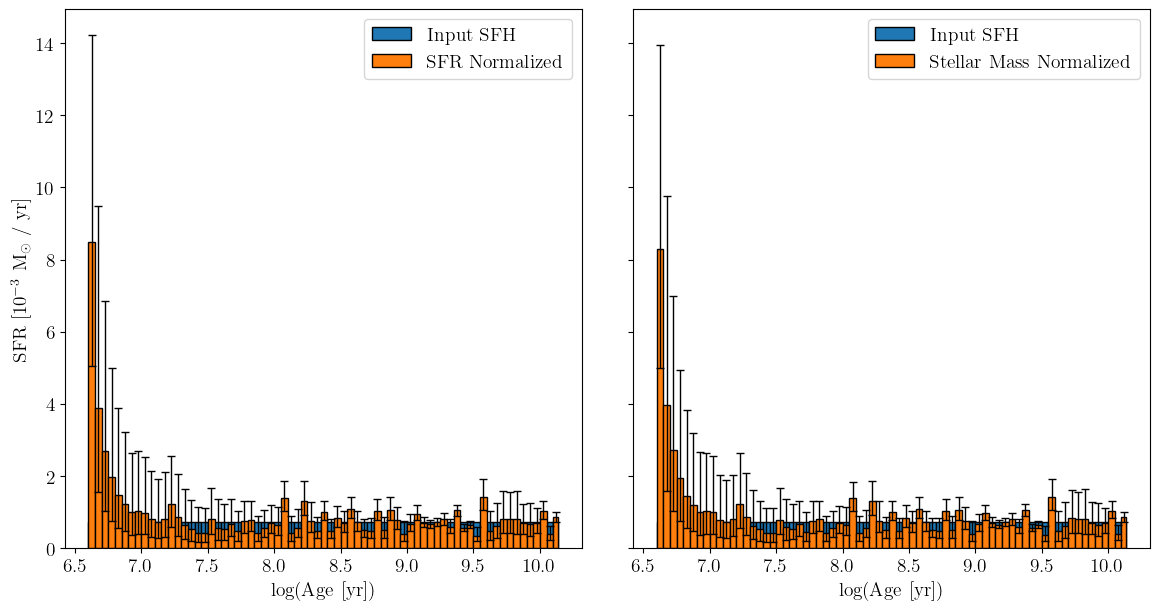

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [77]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_template_logAge, mdf_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.map.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.mle.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_norm_med .- mdf_sfr_norm_lower) .* 1e3, 
        (mdf_sfr_norm_upper .- mdf_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Stellar Mass Normalized")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

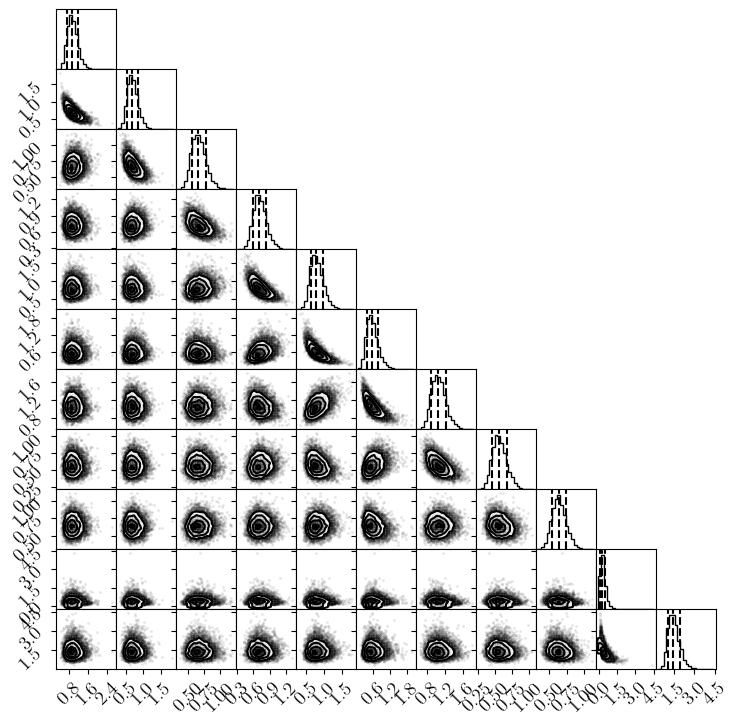

In [86]:
fig=plt.figure(figsize=(7,7))
# corner.corner( permutedims(@view mdf_sfr_sample[end-6:end-3,:]) .* 1e3,
# corner.corner( log.(permutedims(@view mdf_sfr_sample[end-6:end-3,:])) .+ log(1e3),
corner.corner( permutedims(@view mdf_sfr_sample[50:60,:]) .* 1e3,
                # range=[0.1 for i in 1:3],
                #range=[(0,3) for i in 1:3],
                fig=fig,
                # labels=[L"\alpha", L"\beta", L"\sigma"],
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=4,
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

I actually think the overabundance at recent times is due to the way that I am setting the coefficients; I am assuming that the first bin actually spans from present-day to logage of 6.6, which results in much higher stellar mass in that template than perhaps there should be ... I think that may be the problem actually. Should probably require logage to be `length(templates)+1` corresponding to, like, the left-bin edges or something like that.

Fixed that and the issue still hasn't gone away. Something wrong with the prior then? Or maybe it's just a peculiarity with the isochrone / template grid? Try restricting to only logAge > 7 and see what happens. Problem still occurs when cutting out the most recent isochrones.

In [87]:
# Try to solve for data without random error
ttt=similar(data)
ccc = rand(length(free_templates)) .* 10
composite!(ttt,ccc,free_templates)
ttt

99×99 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          6.46814e-13  6.94646e-11  …  0.0          0.0
 7.76822e-9   4.3708e-8    1.19422e-7      0.0          0.0
 3.36025e-7   1.44258e-6   3.48851e-6      0.0          0.0
 7.10986e-6   2.69818e-5   5.97646e-5      0.0          0.0
 9.15873e-5   0.000306694  0.000616304     0.0          0.0
 0.000730586  0.00212707   0.00385148   …  0.0          0.0
 0.00364337   0.00904111   0.014702        0.0          0.0
 0.0114648    0.0236868    0.0345875       0.0          0.0
 ⋮                                      ⋱               
 0.46942      0.623121     0.507595        0.000786418  0.00339244
 0.455988     0.47831      0.413213        0.000597177  0.00174714
 0.380

In [88]:
tmpttt=fit_templates(free_templates, ttt; x0=ones(length(free_templates)).*5)

(map = (μ = [4.038946896173275, 2.4469131455734026, 2.5406255841364973, 2.282653077925975, 6.418724549925712, 5.076879062035752, 2.771381898250626, 1.8153599281501562, 2.865594013920558, 4.538697360372213  …  4.818651440656923, 4.849551985223579, 4.567914595680305, 4.275829278757706, 7.228034165779012, 5.243046992586031, 6.579176307165452, 6.3241776792986775, 6.367079353788243, 6.005422979266948], σ = [3.3385757473806255, 2.2327894851354615, 2.1684537857736577, 1.6030339728040064, 4.980499495532912, 4.387093116619643, 2.5403163002277283, 1.7260720602025807, 2.6323287238402493, 3.998444428484504  …  4.646985577705039, 4.701112407578295, 4.451244728851831, 4.1307288169298895, 6.300764742271833, 4.9131740018492005, 6.452239807691592, 6.204594664130827, 6.235048291218849, 5.8789009064120545], invH = [0.6832602918212368 -0.13258327329156744 … -0.001710635261463406 -0.004371779788062368; -0.1325832732915675 0.832642257994718 … -0.0020573514693810065 -0.0010615679144244375; … ; -0.00171063526

In [89]:
isapprox(tmpttt.mle.μ, ccc; rtol=1e-3)

true